In [31]:
def cleaning_tweets(text):
    ''' Clean tweets with regex patterns
    
    Args : 
        - text : string
    
    Returns : 
        A transformed text
    '''

    text = str(text)
    text = text.lower()

    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"\b[a-zA-Z]\b", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)
    text = re.sub(r"\s+", " ", text)

    text = text.split()

    return text

In [32]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer

df = pd.read_csv('../tweets/tweets_remaining_09042020_16072020.csv', delimiter=';')

df['Date'] = df['created_at'].str.split().str[0]

df = df[df['text'].str.contains("aapl")]

sia = SentimentIntensityAnalyzer()

df['Sentiment'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

sentiment_df = df[['Date', 'Sentiment']]

average_sentiment_df = sentiment_df.groupby('Date').mean().reset_index()

print(average_sentiment_df)


          Date  Sentiment
0   2020-04-09   0.105871
1   2020-04-10   0.083606
2   2020-04-11   0.163910
3   2020-04-12   0.125330
4   2020-04-13   0.127856
..         ...        ...
72  2020-07-12   0.203441
73  2020-07-13   0.144191
74  2020-07-14   0.112571
75  2020-07-15   0.127234
76  2020-07-16   0.132796

[77 rows x 2 columns]


In [33]:
import yfinance as yf
aapl_df = yf.download("aapl", start="2020-04-09", end="2020-07-16", progress=False)

In [34]:
average_sentiment_df['Date'] = pd.to_datetime(average_sentiment_df['Date'])


average_sentiment_df = average_sentiment_df[average_sentiment_df['Date'].isin(aapl_df.index)]
aapl_df = aapl_df[aapl_df.index.isin(average_sentiment_df['Date'])]
average_sentiment_df = average_sentiment_df.reset_index(drop=True)
aapl_df = aapl_df.reset_index(drop=True)

In [35]:
aapl_df['Sentiment'] = average_sentiment_df['Sentiment'].to_numpy()

In [36]:
aapl_df.head()

,Open,High,Low,Close,Adj Close,Volume,Sentiment
0,67.175003,67.517502,66.175003,66.997498,65.342621,161834800,0.105871
1,67.077499,68.425003,66.457497,68.312500,66.625153,131022800,0.127856
2,70.000000,72.062500,69.512497,71.762497,69.989944,194994800,0.072567
3,70.599998,71.582497,70.157501,71.107498,69.351120,131154400,0.134156
4,71.845001,72.050003,70.587502,71.672501,69.902176,157125200,0.131556


In [37]:
aapl_df["Tomorrow"] = aapl_df["Close"].shift(-1)

In [38]:
aapl_df["Target"] = (aapl_df["Tomorrow"] > aapl_df["Close"]).astype(int)


In [39]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(aapl_df[['Open', 'High', 'Low', 'Close',
'Adj Close', 'Volume', 'Sentiment']], aapl_df['Target'], test_size=0.2, random_state=42, shuffle=False)

model = GaussianNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

test_df = aapl_df[aapl_df.index.isin(X_test.index)]

test_df['Predictions'] = y_pred


/var/folders/9f/tqhf2_lj7x9g9w7kvpf8_91r0000gn/T/ipykernel_80984/2058683553.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predictions'] = y_pred


In [40]:
print(test_df)
test_df = test_df.reset_index(drop=True)


         Open       High        Low      Close  Adj Close     Volume   
41  90.019997  91.495003  90.000000  91.199997  89.188103  140223200  \
42  91.279999  91.839996  90.977501  91.027496  89.019417  110737200   
43  91.962502  92.617500  90.910004  91.027496  89.019417  114041600   
44  92.500000  93.945000  92.467499  93.462502  91.400703  118655600   
45  93.852501  94.654999  93.057503  93.172501  91.117081  112424400   
46  94.180000  95.375000  94.089996  95.342499  93.239227  117092000   
47  96.262497  96.317497  94.672501  95.752502  93.640175  125642800   
48  95.334999  95.980003  94.705002  95.919998  93.803986   90257200   
49  97.264999  99.955002  95.257500  95.477501  93.371231  191649200   
50  94.839996  97.254997  93.877502  97.057503  94.916382  170989200   
51  98.989998  99.247498  96.489998  97.724998  95.569168  153198000   

    Sentiment   Tomorrow  Target  Predictions  
41   0.037224  91.027496       0            1  
42   0.162296  91.027496       0       

In [41]:
wallet = 10000
wallet_value = []  
for i in range(len(test_df)):
    if (test_df['Predictions'][i] == 1) and (test_df['Target'][i] == 1):
        wallet += (test_df['Tomorrow'][i] - test_df['Adj Close'][i])
    elif (test_df['Predictions'][i] == 0) and (test_df['Target'][i] == 0):
        wallet += (test_df['Adj Close'][i] - test_df['Tomorrow'][i])
    else:
        wallet -= abs((test_df['Tomorrow'][i] - test_df['Adj Close'][i]))
    wallet_value.append(wallet)

test_df['Wallet'] = wallet_value



         Open       High        Low      Close  Adj Close     Volume   
0    0.000000   0.000000   0.000000   0.000000   0.000000          0  \
1   90.019997  91.495003  90.000000  91.199997  89.188103  140223200   
2   91.279999  91.839996  90.977501  91.027496  89.019417  110737200   
3   91.962502  92.617500  90.910004  91.027496  89.019417  114041600   
4   92.500000  93.945000  92.467499  93.462502  91.400703  118655600   
5   93.852501  94.654999  93.057503  93.172501  91.117081  112424400   
6   94.180000  95.375000  94.089996  95.342499  93.239227  117092000   
7   96.262497  96.317497  94.672501  95.752502  93.640175  125642800   
8   95.334999  95.980003  94.705002  95.919998  93.803986   90257200   
9   97.264999  99.955002  95.257500  95.477501  93.371231  191649200   
10  94.839996  97.254997  93.877502  97.057503  94.916382  170989200   
11  98.989998  99.247498  96.489998  97.724998  95.569168  153198000   

    Sentiment   Tomorrow  Target  Predictions        Wallet  
0

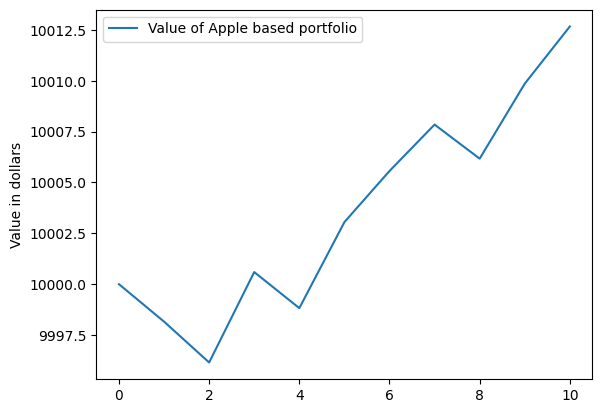

In [42]:
wallet_df = test_df.copy()
wallet_df = wallet_df.drop(wallet_df.index[0:60])

wallet_df.loc[-1] = [0] * len(wallet_df.columns)
wallet_df.index = wallet_df.index + 1
wallet_df = wallet_df.sort_index()
wallet_df.loc[0, 'Wallet'] = 10000


wallet_df = wallet_df.reset_index(drop=True)
wallet_df = pd.concat([wallet_df, test_df], ignore_index=True)


print(wallet_df)

plt.plot(wallet_df['Wallet'], label='Value of Apple based portfolio')
plt.ylabel('Value in dollars')
plt.legend()
plt.show()



In [43]:
print((wallet_df['Wallet'][len(wallet_df)-2] - wallet_df['Wallet'][0])/wallet_df['Wallet'][0]*100)


0.1266370391845703
